In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


import numpy as np
import torch
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.optimize import minimize




from tqdm import tqdm

import medmnist
from medmnist import INFO, Evaluator

# Data Preparation

In [2]:
print(medmnist.__version__)
# note there is also mednist+!!

3.0.2


In [3]:
from medmnist import BreastMNIST

train_dataset = BreastMNIST(split='train', download=True)
test_dataset  = BreastMNIST(split='test', download=True)

Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz


In [4]:
train_dataset.info

{'python_class': 'BreastMNIST',
 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1',
 'MD5': '750601b1f35ba3300ea97c75c52ff8f6',
 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1',
 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364',
 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1',
 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1',
 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1',
 'MD5_224

Note: normal + benign are combined into one class: benign!

In [5]:
print(len(train_dataset))

546


## Convert medmnist datset object into pandas dataframe

In [6]:
# save images and labels in a list
images = []
labels = []

for img, label in train_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [7]:
# create a df of the extracted data
train_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [8]:
train_df.head()

,image,label
0,"[[139, 139, 138, 139, 142, 149, 156, 159, 164,...",1
1,"[[82, 85, 83, 78, 76, 76, 79, 79, 76, 80, 86, ...",1
2,"[[157, 155, 151, 145, 149, 146, 141, 134, 141,...",1
3,"[[167, 163, 162, 151, 145, 133, 139, 149, 150,...",1
4,"[[1, 6, 41, 79, 159, 180, 175, 175, 175, 181, ...",0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   546 non-null    object
 1   label   546 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [10]:
train_df["label"].value_counts()

label
1    399
0    147
Name: count, dtype: int64

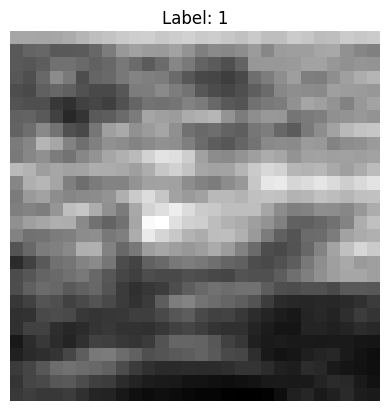

In [11]:
# define a sample
sample = train_df.iloc[0]

img_np = sample["image"] 
label  = sample["label"]

plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [12]:
print("shape:",img_np.shape)

shape: (28, 28)


In [13]:
# save images and labels in a list
images = []
labels = []

for img, label in test_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [14]:
# create a df of the extracted data
test_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

In [16]:
# device definition: gpu/ cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [17]:
X_train = np.stack(train_df['image'].values)
y_train = np.array(train_df['label'].values)

X_test = np.stack(test_df['image'].values)
y_test = np.array(test_df['label'].values)

In [18]:
X_train.shape

(546, 28, 28)

In [19]:
X_train.shape

(546, 28, 28)

In [20]:
# PCA expects array of dim 2 as input --> flatten the 28x28 matrix to 784 features
X_train_flat = X_train.reshape(X_train.shape[0], -1) # X_train.shape[0] keeps number of samples, -1 flattens everything else in one long vector
X_test_flat  = X_test.reshape(X_test.shape[0], -1)
X_train_flat.shape

(546, 784)

In [21]:
# Apply PCA
n_features = 8
pca = PCA(n_components=n_features)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca  = pca.transform(X_test_flat)

In [22]:
print(X_train_pca.shape)  # (546, 8)
print(X_test_pca.shape)   # (whatever test samples, 8)

(546, 8)
(156, 8)


In [23]:
# convert X,y into torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
y__train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

In [24]:
# Convert to tensors
X_train_t = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test, dtype=torch.long).to(device)

# QCNN Approach 1 - Image classifier

In [25]:
def parity_probs(model, fparams, aparams, X, theta):
    """Compute [p0, p1] for every input x in X."""
    out = []
    for x in X:
        bind = {p: float(v) for p, v in zip(fparams, x)}
        bind.update({p: float(v) for p, v in zip(aparams, theta)})

        sv = Statevector.from_instruction(model.assign_parameters(bind))
        dist = sv.probabilities_dict()

        p1 = sum(p for bit, p in dist.items() if bit.count("1") % 2 == 1)
        out.append([1 - p1, p1])
    return np.array(out)

def xent(probs, y_onehot, eps=1e-12):
    return float(-np.mean(np.sum(y_onehot * np.log(probs + eps), axis=1)))


In [ ]:
qubit_list = [1, 2, 5, 10]
max_iterations = 60

results = {
    'n_qubits': [],
    'train_loss': [],
    'train_acc': [],
    'test_acc': [],
    'test_auc': [],
    'n_params': []
}

: 

In [ ]:
for n_qubits in qubit_list:
    print(f"\n===== TRAINING {n_qubits} QUBITS =====")

    # Build circuit
    feature_map = ZFeatureMap(n_qubits, reps=1)
    ansatz      = RealAmplitudes(n_qubits, reps=1)

    model = QuantumCircuit(n_qubits)
    model.compose(feature_map, inplace=True)
    model.compose(ansatz, inplace=True)

    fparams = list(feature_map.parameters)
    aparams = list(ansatz.parameters)
    n_params = len(aparams)

    theta0 = np.zeros(n_params)

    # Objective for optimizer
    def objective(theta):
        probs = parity_probs(model, fparams, aparams, X_train_theta, theta)
        return xent(probs, y_train_oh)

    # Train parameters
    try:
        res = minimize(objective, theta0, method="Powell",
                       options={"maxiter": max_iterations})
        theta_opt = res.x
        best_loss = res.fun
        print("Optimized with Powell.")
    except Exception:
        print("Powell failed → using COBYLA...")
        opt = COBYLA(maxiter=max_iterations, tol=1e-3)
        res = opt.minimize(objective, x0=theta0)
        theta_opt = res.x
        best_loss = res.fun

    # --------------------------
    # Evaluate on full train set
    # --------------------------
    train_probs = parity_probs(model, fparams, aparams, X_train_theta, theta_opt)
    train_pred  = np.argmax(train_probs, axis=1)
    train_label = np.argmax(y_train_oh, axis=1)

    train_acc = accuracy_score(train_label, train_pred)

    # ------------------------
    # Evaluate on full test set
    # ------------------------
    test_probs = parity_probs(model, fparams, aparams, X_test_theta, theta_opt)
    test_pred  = np.argmax(test_probs, axis=1)

    test_acc = accuracy_score(y_test, test_pred)
    test_auc = roc_auc_score(y_test, test_probs[:,1])

    # Store results
    results['n_qubits'].append(n_qubits)
    results['train_loss'].append(best_loss)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)
    results['test_auc'].append(test_auc)
    results['n_params'].append(n_params)

    print(f"Train loss: {best_loss:.4f}")
    print(f"Train acc:  {train_acc:.3f}")
    print(f"Test  acc:  {test_acc:.3f}")
    print(f"Test  AUC:  {test_auc:.3f}")
    print(f"Params:     {n_params}")


Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_14280/3114810135.py", line 25, in <module>
  File "/Users/ramonwinkler/anaconda3/envs/minerva/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 687, in minimize
    res = _minimize_powell(fun, x0, args, callback, bounds, **options)
  File "/Users/ramonwinkler/anaconda3/envs/minerva/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 3335, in _minimize_powell
    fval = squeeze(func(x))
  File "/Users/ramonwinkler/anaconda3/envs/minerva/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 569, in function_wrapper
    fx = function(np.copy(x), *(wrapper_args + args))
  File "/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_14280/3114810135.py", line 20, in object


===== TRAINING 1 QUBITS =====
Powell failed → using COBYLA...


In [ ]:
# ============================================================
# Quantum Image Classifier (Clean Script)
# Loops over qubits: [1, 2, 5, 10]
# Uses all train and test data
# Checks class imbalance
# Evaluates train/test accuracy and AUC
# ============================================================

import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.optimize import minimize

# ============================================================
# 0. SHOW CLASS IMBALANCE
# ============================================================

def show_class_imbalance(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n=== Class Imbalance in {name} ===")
    for cls, cnt in zip(unique, counts):
        print(f"Class {cls}: {cnt} samples")
    print(f"Ratio (minority/majority): {min(counts)}/{max(counts)}")

show_class_imbalance(y_train, "Train Set")
show_class_imbalance(y_test, "Test Set")


# ============================================================
# 1. PCA → Angle Encoding
# ============================================================

# angle scaling to [0, π]
mins = X_train_pca.min(axis=0)
maxs = X_train_pca.max(axis=0)
denom = np.where((maxs - mins) == 0, 1, (maxs - mins))

def to_angles(X):
    """Normalize PCA features to [0, π] for rotation angles."""
    return (X - mins) / denom * np.pi

X_train_theta = to_angles(X_train_pca)
X_test_theta  = to_angles(X_test_pca)

# One-hot labels for cross entropy
y_train_oh = np.eye(2)[y_train]
y_test_oh  = np.eye(2)[y_test]


# ============================================================
# 2. HELPERS: Build circuit + compute probabilities
# ============================================================

def build_model_circuit(n_qubits):
    """Create feature map + ansatz + full model."""
    fm = ZFeatureMap(n_qubits, reps=1)
    an = RealAmplitudes(n_qubits, reps=1)

    qc = QuantumCircuit(n_qubits)
    qc.compose(fm, inplace=True)
    qc.compose(an, inplace=True)

    return qc, list(fm.parameters), list(an.parameters)


def build_bound_circuit(model, fparams, aparams, x, theta):
    """Assign PCA features (x) + trainable parameters (theta)."""
    bind = {p: float(v) for p, v in zip(fparams, x)}
    bind.update({p: float(v) for p, v in zip(aparams, theta)})
    return model.assign_parameters(bind)


def parity_probabilities(X, model, fparams, aparams, theta):
    """
    Return Nx2 array of class probabilities:
    p0 = even parity
    p1 = odd parity
    """
    probs = []

    for x in X:
        sv = Statevector.from_instruction(
            build_bound_circuit(model, fparams, aparams, x, theta)
        )
        dist = sv.probabilities_dict()

        p1 = sum(p for bit, p in dist.items() if bit.count("1") % 2 == 1)
        probs.append([1 - p1, p1])

    return np.array(probs)


def cross_entropy(probs, y_onehot, eps=1e-12):
    """Binary cross entropy."""
    return -np.mean(np.sum(y_onehot * np.log(probs + eps), axis=1))


# ============================================================
# 3. MAIN LOOP: Train & Evaluate for Different Qubit Counts
# ============================================================

qubit_list = [1, 2, 5, 10]
max_iterations = 60

results = {
    "n_qubits": [],
    "train_acc": [],
    "test_acc": [],
    "test_auc": [],
    "n_params": [],
    "train_loss": []
}

print("\n==================== START TRAINING ====================")

for n_qubits in qubit_list:
    print(f"\n\n=== Training with {n_qubits} qubits ===")

    # --------------------------------------------------------
    # Build model
    # --------------------------------------------------------
    model, fparams, aparams = build_model_circuit(n_qubits)
    n_params = len(aparams)

    print(f"Trainable parameters = {n_params}")

    # --------------------------------------------------------
    # TRAINING (all training data)
    # --------------------------------------------------------

    def objective(theta):
        probs = parity_probabilities(X_train_theta, model, fparams, aparams, theta)
        return cross_entropy(probs, y_train_oh)

    theta0 = np.zeros(n_params, dtype=float)

    try:
        res = minimize(
            objective,
            theta0,
            method="Powell",
            options={"maxiter": max_iterations, "disp": False},
        )
        theta_opt = res.x
        best_loss = res.fun
        print("Optimizer: SciPy Powell")
    except Exception:
        opt = COBYLA(maxiter=max_iterations)
        res = opt.minimize(objective, x0=theta0)
        theta_opt = res.x
        best_loss = objective(theta_opt)
        print("Optimizer: COBYLA (fallback)")

    print(f"Best train loss = {best_loss:.4f}")

    # --------------------------------------------------------
    # EVALUATE
    # --------------------------------------------------------

    # TRAIN SET
    train_probs = parity_probabilities(X_train_theta, model, fparams, aparams, theta_opt)
    train_pred  = np.argmax(train_probs, axis=1)
    train_acc   = accuracy_score(y_train, train_pred)

    # TEST SET
    test_probs = parity_probabilities(X_test_theta, model, fparams, aparams, theta_opt)
    test_pred  = np.argmax(test_probs, axis=1)
    test_acc   = accuracy_score(y_test, test_pred)

    # TEST AUC
    test_auc = roc_auc_score(y_test, test_probs[:, 1])

    print(f"Train accuracy = {train_acc:.3f}")
    print(f"Test accuracy  = {test_acc:.3f}")
    print(f"Test AUC       = {test_auc:.3f}")

    # --------------------------------------------------------
    # SAVE RESULTS
    # --------------------------------------------------------
    results["n_qubits"].append(n_qubits)
    results["n_params"].append(n_params)
    results["train_loss"].append(best_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)
    results["test_auc"].append(test_auc)

print("\n==================== DONE ====================")
print("\nResults:", results)
